## **Housing Prices Advanced Regression : EDA and Regression Models**

This notebook demonstrates how various data pre-processing hypotheses established during an Exploratory Data Analysis (EDA) can be tested against the performance of a simple baseline model - established at the onset. Once data pre-processing is optimized to a satisfactory level, various models and hyperparameters are tested to further improve the model accuracy.


Sources:

* https://www.kaggle.com/code/ryannolan1/kaggle-housing-youtube-video

* https://github.com/gvndkrishna/Kaggle-House-Price-Prediction/blob/main/House-Price-Prediction-Solution.ipynb

## CONTENTS:

[ **1 ) Importing the Modules and Loading the Dataset**](#content1)

[ **2 ) Exploratory Data Analysis (EDA)**](#content2)

[ **3 ) Missing Values Treatment**](#content3)

[ **4 ) Handling Skewness of Features**](#content4)

[ **5 ) Prepare the Data**](#content5)

[ **6 ) Regression Models**](#content6)

[ **7 ) Saving and Making Submission to Kaggle**](#content7)

<a id="content1"></a>
## 1) Importing the Modules and Loading the Dataset

In [354]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.legend_handler import HandlerBase
import seaborn as sns
import missingno as msno
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import the necessary modelling algos.

#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,ElasticNet
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

from scipy import stats
from scipy.stats import norm, skew   # specifically for staistics
from pandas.api.types import CategoricalDtype
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression




In [355]:
train=pd.read_csv("train.csv", index_col="Id")
test=pd.read_csv("test.csv", index_col="Id")

In [356]:
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [357]:
test.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


<a id="content2"></a>
## 2) Baseline 

## 2.1 ) Merging the training and test data sets

The training and test sets are joined such that their analysis and preprocessing is completed together

In [358]:
all_data=pd.concat([train,test])
print(all_data.loc[test.index,'SalePrice'])  
#confirming the all_data dataframe has one less columns as a result of dropping the target column
print(all_data.shape)

Id
1461   NaN
1462   NaN
1463   NaN
1464   NaN
1465   NaN
        ..
2915   NaN
2916   NaN
2917   NaN
2918   NaN
2919   NaN
Name: SalePrice, Length: 1459, dtype: float64
(2919, 80)


In [359]:
#columns in train dataframe that are not the test dataframe
print(list(set(train.columns) - set(test.columns)))
print(all_data.shape, train.shape, test.shape)

['SalePrice']
(2919, 80) (1460, 80) (1459, 79)


Might be useful when we consider features of different data types.

In [360]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [361]:
all_data.index # the indices of the rows.

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919],
           dtype='int64', name='Id', length=2919)

## 2.2 ) Minor cleanup of Data

In [362]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    
    #This is the effective line for the score
    # Some values of GarageYrBlt are corrupt (index 2593 is year 2027), so we'll replace them
    # with the year the house was built - this line also imputed NaN values with the YearBuilt
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

all_data = clean(all_data)

## 2.3 ) Separate Dataframes (depending on data type)

### Encode the Statistical Data Type
Pandas has Python types corresponding to the standard statistical types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. As seen above, the data types are distributed as follows: dtypes: float64(12), int64(25), object(43)

This cell defines the encode function:

In [363]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete)
# The categoricals we'll need to do ourselves (at this point in time they are "object").
#Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(1,11))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values in ordinal categorical features
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

#Code confirming the difference between the "object" and "category" features

ordered_list = []
for key, value in ordered_levels.items():
    ordered_list.append(key)
    
categorical_columns = ordered_list + features_nom

print(set(categorical_columns) - set(train.select_dtypes(["object"])))    


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

#encode is necessary, as it creates categorical variables from objects, and those are used for label encoding
#in the scoring function (the model doesnt accept strings, only numbers)
all_data = encode(all_data)

{'MSSubClass', 'OverallQual', 'OverallCond'}


#### CATEGORICAL FEATURES

In [364]:
cat_df=all_data.select_dtypes(include='category')

In [365]:
cat_df.head(10)
cat_df.shape

(2919, 46)

In [366]:
cat_df.columns   # list of the categorical columns.

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

#### NUMERIC FEATURES

In [367]:
num_df=all_data.select_dtypes(include='number')
num_df.shape

(2919, 34)

In [368]:
num_df.columns # list of numeric columns.

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF',
       'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'Threeseasonporch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

## 2.4 ) Check for Missing Values

In [369]:
all_data.isnull().sum().sort_values(ascending = False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
                ... 
FirstFlrSF         0
SecondFlrSF        0
LowQualFinSF       0
GrLivArea          0
CentralAir         0
Length: 80, dtype: int64

<AxesSubplot:>

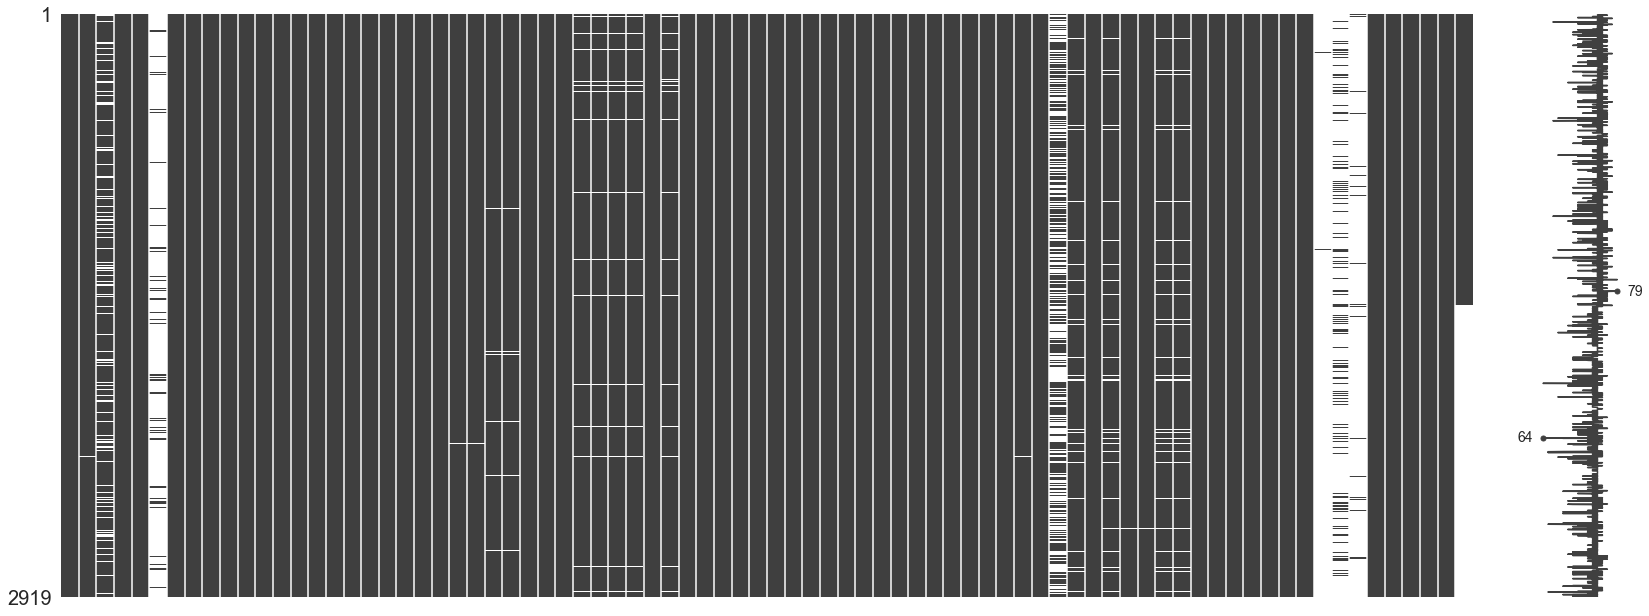

In [370]:
msno.matrix(all_data) # just to visulaize the missing values per column

* #### Many columns have missing values and that will be treated later in the notebook.

#### FEATURES WITH MISSING VALUES

In [371]:
nan_df=all_data.loc[:, all_data.isna().any()]
nan_df.shape
nan_df.columns   # list of columns with missing values.
print(len(nan_df.columns))

#Alternatively 
cols_with_missing_values = [col for col in all_data.columns if all_data[col].isna().any()]
print(len(cols_with_missing_values))


34
34


### Handle Missing Values simply
Handling missing values now will make the feature engineering go more smoothly. We'll impute 0 for missing numeric values and "None" for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: 1 whenever a value was imputed and 0 otherwise.

In [372]:
def impute(df):
    
    df_imputed = df.copy()
    
    for name in df_imputed.select_dtypes("number"):
        df_imputed[name] = df_imputed[name].fillna(0)
    for name in df_imputed.select_dtypes("category"):
        df_imputed[name] = df_imputed[name].fillna("None")
    return df_imputed

# improves results, but it seems like NaN values are accepted (int64 data type)
all_data_simple_impute = impute(all_data)


### Handle Missing Values in a more involved manner



In this section of the notebook missing values will be dealt with using more care. Previously numerical data were filled with 0 and categorical with "None". It is important to consider the following questions prior to imputing data:
* What is the reason for the nan values? No recording or because the feature e.g. pool is non existent at a given index e.g. house
* What other features can give us a good idea how to impute data which has not been recorded

In [373]:
all_data_complex_impute = all_data.copy()

In [374]:
#For PoolQC, will impute missing values with "None" if the corresponing recording has a zero PoolArea. 
#Otherwise, the mode within the category will be used

"""
# Compute mode once
pool_qc_mode = all_data_complex_impute["PoolQC"].mode()[0]

# Loop through missing PoolQC values
for index in all_data_complex_impute.PoolQC[all_data_complex_impute.PoolQC.isna()].index:
    if all_data_complex_impute.loc[index, "PoolArea"] == 0:
        all_data_complex_impute.loc[index, "PoolQC"] = "None"
    else:
        all_data_complex_impute.loc[index, "PoolQC"] = pool_qc_mode  # Use precomputed mode
"""
#more efficient vectorized approach

# Assign "None" where PoolArea is 0
all_data_complex_impute.loc[all_data_complex_impute["PoolArea"] == 0, "PoolQC"] = "None"

# Assign mode where PoolQC is still NaN
pool_qc_mode = all_data_complex_impute["PoolQC"].mode()[0]
all_data_complex_impute["PoolQC"].fillna(pool_qc_mode, inplace=True)


In [375]:
all_data_complex_impute[["Alley", "Fence"]] = all_data_complex_impute[["Alley", "Fence"]].fillna("None")


In [376]:
all_data_complex_impute.loc[all_data_complex_impute.Fireplaces == 0, "FireplaceQu"] = "None"

fireplace_qu_mode = all_data_complex_impute.FireplaceQu.mode()[0]
 
all_data_complex_impute.FireplaceQu.fillna(fireplace_qu_mode, inplace = True)


In [377]:
#To save time

all_data_complex_impute.drop("MiscFeature", axis = 1, inplace = True)

In [378]:
#filling NA with "median"
all_data_complex_impute["LotFrontage"] = all_data_complex_impute.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median())) #grouping by Neighborhood

In [379]:
all_data_complex_impute.loc[all_data_complex_impute.GarageArea == 0, ["GarageCond", "GarageQual", "GarageFinish", "GarageType"]] = "None"


for feature in ["GarageCond", "GarageQual", "GarageFinish"]:
    mode = all_data_complex_impute[feature].mode()[0]
 
    all_data_complex_impute[feature].fillna(mode, inplace = True)



In [380]:
basement_categorical = ["BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]

basement_numerical = ["BsmtFullBath", "BsmtHalfBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]

print(all_data_complex_impute.loc[2121, basement_categorical + basement_numerical])

BsmtExposure    NaN
BsmtCond        NaN
BsmtQual        NaN
BsmtFinType2    NaN
BsmtFinType1    NaN
BsmtFullBath    NaN
BsmtHalfBath    NaN
BsmtFinSF1      NaN
BsmtFinSF2      NaN
BsmtUnfSF       NaN
TotalBsmtSF     NaN
Name: 2121, dtype: object


In [381]:
all_data_complex_impute.loc[all_data_complex_impute.TotalBsmtSF == 0, basement_categorical] = "None"

all_data_complex_impute.loc[2121, basement_categorical] = "None"

for feature in basement_categorical:
    mode = all_data_complex_impute[feature].mode()[0]
 
    all_data_complex_impute[feature].fillna(mode, inplace = True)

In [382]:
all_data_complex_impute.loc[2121, basement_numerical] = 0

for feature in basement_numerical:
    mode = all_data_complex_impute[feature].mode()[0]
 
    all_data_complex_impute[feature].fillna(mode, inplace = True)


In [383]:
mask = all_data_complex_impute["MasVnrType"].isna() & all_data_complex_impute["MasVnrArea"].isna()

all_data_complex_impute.loc[mask, "MasVnrType"] = "None"
all_data_complex_impute.loc[mask, "MasVnrArea"] = 0

all_data_complex_impute["MasVnrType"].fillna(all_data_complex_impute["MasVnrType"].mode()[0], inplace = True)


In [384]:
features_modefill = ["MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual", "Functional"]
#filling NA with "Mode" i.e Most-frequently occuring
all_data_complex_impute[features_modefill] = all_data_complex_impute.groupby("Neighborhood")[features_modefill].transform(lambda x:x.fillna(x.mode()[0])) #grouping by Neighborhood


In [385]:
mask = all_data_complex_impute["GarageArea"].isna() & all_data_complex_impute["GarageCars"].isna()

all_data_complex_impute.loc[mask, "GarageArea"] = 0
all_data_complex_impute.loc[mask, "GarageCars"] = 0



In [386]:
nan_all_data = (all_data_complex_impute.isnull().sum())
nan_all_data= nan_all_data.drop(nan_all_data[nan_all_data== 0].index).sort_values(ascending=False)
nan_all_data
miss_df = pd.DataFrame({'Missing Ratio' :nan_all_data})
miss_df


,Missing Ratio
SalePrice,1459


## 2.5 ) Finally, let's establish a baseline score to judge our feature engineering against.

Here is the function we created in Lesson 1 that will compute the cross-validated RMSLE score for a feature set. We've used XGBoost for our model, but you might want to experiment with other models.

In [492]:
def score_dataset(X, y, model=None):
    
    if model is None:
        model = XGBRegressor()
    
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    
    
    # Compute Training Error
    model.fit(X, log_y)  # Train on full dataset
    train_preds = model.predict(X)  # Predict on training data
    train_mse = np.mean((train_preds - log_y) ** 2)  # MSE
    train_rmsle = np.sqrt(train_mse)  # RMSLE    
    
    cv_msle = -cross_val_score(model, X, log_y, cv=20, scoring="neg_mean_squared_error").mean()
    cv_rmsle = np.sqrt(cv_msle)

    return {"Training RMSLE": train_rmsle, "CV RMSLE": cv_rmsle}


We can reuse this scoring function anytime we want to try out a new feature set. We'll run it now on the processed data with no additional features and get a baseline score. 

In [388]:
X = all_data_simple_impute.loc[train.index, :].copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline training score: {baseline_score['Training RMSLE']:.5f} RMSLE")
print(f"Baseline CV score: {baseline_score['CV RMSLE']:.5f} RMSLE")

Baseline training score: 0.00829 RMSLE
Baseline CV score: 0.13527 RMSLE


In [389]:
X = all_data_complex_impute.loc[train.index, :].copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Improved imputation training score: {baseline_score['Training RMSLE']:.5f} RMSLE")
print(f"Improved imputation CV score: {baseline_score['CV RMSLE']:.5f} RMSLE")

Improved imputation training score: 0.00748 RMSLE
Improved imputation CV score: 0.13481 RMSLE


<a id="content3"></a>
## 3) Exploratory Data Analysis


## 3.1 ) Analyzing the Target i.e. 'SalePrice'

Skewness: 1.882876
Kurtosis: 6.536282


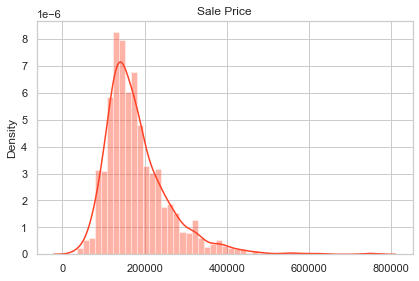

In [390]:
df = all_data.loc[train.index,:].copy()

# analyzing the target variable ie 'Saleprice'
sns.distplot(a=df['SalePrice'],color='#ff4125',axlabel=False).set_title('Sale Price')
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

#### **The distribution of target is a bit right skewed and shows peakedness (kurtosis). Hence taking the 'log transform' is a reasonable option.**

#### ALSO LINEAR REGRESSION IS BASED ON THE ASSUMPTION OF THE 'HOMOSCADESITY' AND HENCE TAKING LOG WILL  BE A GOOD IDEA TO ENSURE 'HOMOSCADESITY' (that the varince of errors is constant.). A bit scary but simple ;) 

**You can read more about this on wikipedia.**

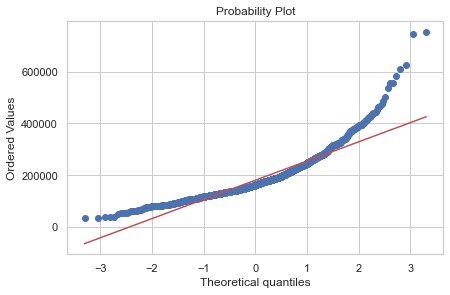

In [391]:
#Get also the qq-plot (the quantile-quantile plot)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

####  TAKING 'Log Transform' OF THE TARGET

Note, the transformation is on the copy of the train dataframe - not on the all_data dataframe. This is to test the result of the hypothesis below, which confirms that using the log transform removes the skewness. This justifies the scoring methodology of this competition. 

In [392]:
df['SalePrice']=np.log1p(df['SalePrice']) 

Text(0.5, 1.0, 'log(1+SalePrice)')

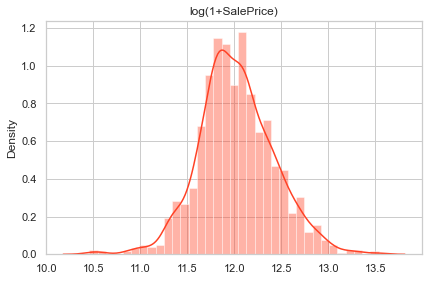

In [393]:
# now again see the distribution.
sns.distplot(a=df['SalePrice'],color='#ff4125',axlabel=False).set_title('log(1+SalePrice)')  # better.


<a id="content4"></a>
## 3.2) Feature Engineering




This uses domain-based knowledge and intuition to create new features

In [574]:
feature_engineering = all_data_complex_impute.copy()

In [575]:
#LowQualFinSF – Finished low-quality space (e.g., partially finished rooms, enclosed porches, or attic spaces that are counted but not high quality).

feature_engineering["total"] = feature_engineering["FirstFlrSF"] + feature_engineering["SecondFlrSF"] + feature_engineering["LowQualFinSF"]

print(feature_engineering["total"].equals(feature_engineering["GrLivArea"]))

feature_engineering["TotalBasement"] = feature_engineering["BsmtFinSF1"] + feature_engineering["BsmtFinSF2"] + feature_engineering["BsmtUnfSF"]  

print(feature_engineering["TotalBasement"].equals(feature_engineering["TotalBsmtSF"]))

feature_engineering = feature_engineering.drop(["total","TotalBasement"], axis = 1)

True
True


Followed a stepwise procedure where features were introduced one at a time, and the addition of the feature along with the dropping of constituent features were tested against the baseline. Score improvements were used to decide what to keep and what not.

In [576]:
feature_engineering = all_data_complex_impute.copy()

feature_engineering["houseage_new"] = feature_engineering['YrSold'] - feature_engineering['YearRemodAdd']

feature_engineering = feature_engineering.drop(["YrSold", "YearRemodAdd"], axis = 1)

feature_engineering["PorchTypes"] = feature_engineering[[
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "Threeseasonporch",
    "ScreenPorch",
]].gt(0.0).sum(axis=1)

feature_engineering["MedNhbdArea"] = feature_engineering.groupby("Neighborhood")["GrLivArea"].transform("median")

feature_engineering['Pool_new'] = feature_engineering['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

feature_engineering = feature_engineering.drop(["PoolArea"], axis = 1)

feature_engineering['2ndFloor_new'] = feature_engineering['SecondFlrSF'].apply(lambda x: 1 if x > 0 else 0)

feature_engineering['Garage_new'] = feature_engineering['GarageCars'].apply(lambda x: 1 if x > 0 else 0)

feature_engineering = feature_engineering.drop(["GarageCars"], axis = 1)

feature_engineering['Fireplace_new'] = feature_engineering['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

feature_engineering = feature_engineering.drop(["Fireplaces"], axis = 1)


In [559]:
#Testing baseline vs new feature vs drop constituents

X = all_data_complex_impute.loc[train.index, :].copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Improved imputation training score: {baseline_score['Training RMSLE']:.5f} RMSLE")
print(f"Improved imputation CV score: {baseline_score['CV RMSLE']:.5f} RMSLE")

X = feature_engineering.loc[train.index, :].copy()
y = X.pop("SalePrice")

feature_engineering_score = score_dataset(X, y)
print(f"Feature engineering training score: {feature_engineering_score['Training RMSLE']:.5f} RMSLE")
print(f"Feature engineering  CV score: {feature_engineering_score['CV RMSLE']:.5f} RMSLE")


Improved imputation training score: 0.00748 RMSLE
Improved imputation CV score: 0.13998 RMSLE
Feature engineering training score: 0.00802 RMSLE
Feature engineering  CV score: 0.13374 RMSLE


In [545]:
"""
#Tested with no success

feature_engineering_test["houseage_new"] = feature_engineering_test['YrSold'] - feature_engineering_test['YearBuilt']

feature_engineering_test['totalarea_new'] = feature_engineering_test['GrLivArea'] + feature_engineering_test['TotalBsmtSF']

feature_engineering_test['totalbaths_new'] = feature_engineering_test['BsmtFullBath'] + feature_engineering_test['FullBath'] + 0.5 * (feature_engineering_test['BsmtHalfBath'] + feature_engineering_test['HalfBath']) 

feature_engineering_test['totalporchsf_new'] = feature_engineering_test['OpenPorchSF'] + feature_engineering_test['Threeseasonporch'] + feature_engineering_test['EnclosedPorch'] + feature_engineering_test['ScreenPorch'] + feature_engineering_test['WoodDeckSF']

feature_engineering_test["LivLotRatio"] = feature_engineering_test.GrLivArea / feature_engineering_test.LotArea

feature_engineering_test["Spaciousness"] = (feature_engineering_test.FirstFlrSF + feature_engineering_test.SecondFlrSF) / feature_engineering_test.TotRmsAbvGrd

feature_engineering_test = pd.get_dummies(feature_engineering_test, columns=["BldgType"], prefix="Bldg")
for col in feature_engineering_test.filter(like="Bldg_").columns:
    feature_engineering_test[col] *= feature_engineering_test.GrLivArea
    
feature_engineering_test['Bsmt_new'] = feature_engineering_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

#Logical features
feature_engineering_test['Porch_new'] = feature_engineering_test['totalporchsf_new'].apply(lambda x: 1 if x > 0 else 0)

#Tested with success
feature_engineering_test["houseage_new"] = feature_engineering_test['YrSold'] - feature_engineering_test['YearRemodAdd'] #drop

feature_engineering_test["PorchTypes"] = feature_engineering_test[[
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "Threeseasonporch",
    "ScreenPorch",
]].gt(0.0).sum(axis=1) #no drop

feature_engineering_test["MedNhbdArea"] = feature_engineering_test.groupby("Neighborhood")["GrLivArea"].transform("median")

feature_engineering_test['Pool_new'] = feature_engineering_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
feature_engineering_test['2ndFloor_new'] = feature_engineering_test['SecondFlrSF'].apply(lambda x: 1 if x > 0 else 0)
feature_engineering_test['Garage_new'] = feature_engineering_test['GarageCars'].apply(lambda x: 1 if x > 0 else 0)
feature_engineering_test['Fireplace_new'] = feature_engineering_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


#To test


"""



'\n#Tested with no success\n\nfeature_engineering_test["houseage_new"] = feature_engineering_test[\'YrSold\'] - feature_engineering_test[\'YearBuilt\']\n\nfeature_engineering_test[\'totalarea_new\'] = feature_engineering_test[\'GrLivArea\'] + feature_engineering_test[\'TotalBsmtSF\']\n\nfeature_engineering_test[\'totalbaths_new\'] = feature_engineering_test[\'BsmtFullBath\'] + feature_engineering_test[\'FullBath\'] + 0.5 * (feature_engineering_test[\'BsmtHalfBath\'] + feature_engineering_test[\'HalfBath\']) \n\nfeature_engineering_test[\'totalporchsf_new\'] = feature_engineering_test[\'OpenPorchSF\'] + feature_engineering_test[\'Threeseasonporch\'] + feature_engineering_test[\'EnclosedPorch\'] + feature_engineering_test[\'ScreenPorch\'] + feature_engineering_test[\'WoodDeckSF\']\n\nfeature_engineering_test["LivLotRatio"] = feature_engineering_test.GrLivArea / feature_engineering_test.LotArea\n\nfeature_engineering_test["Spaciousness"] = (feature_engineering_test.FirstFlrSF + feature_en

## 3.3 ) Feature selection

What needs to be done now is:
* Features engineered must be compared with their constituents to decide what to keep: due to inherent collinearity, the least informative - the engineered feature or its constituents - will be dropped
* Assess whether strong collinearities between existing features would justify dropping
* Drop features presenting limited information about the target

## Mutual Information

Mutual information can be used to compute a utility score for a feature, giving you an indication of how much potential the feature has. Compared to corrrelation, this metric is not limited to numerical features and can be used to infer non-linear relationships between features and the target.

In [565]:
def make_mi_scores(dataframe):
    df = dataframe.copy()
    X = df.loc[train.index, :].copy()
    y = X.pop("SalePrice")
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    
mi_scores = make_mi_scores(feature_engineering)

## Remove low mutual information features

In [566]:
def drop_uninformative(df, mi_scores):
    cols_to_drop = mi_scores[mi_scores == 0.0].index.to_list()
    return df.drop(cols_to_drop, axis = 1)

In [567]:
X = feature_engineering.loc[train.index, :].copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Feature Engineering training score: {baseline_score['Training RMSLE']:.5f} RMSLE")
print(f"Feature Engineering CV score: {baseline_score['CV RMSLE']:.5f} RMSLE")

mi_scores = make_mi_scores(feature_engineering)

strong_mi = feature_engineering.copy()

strong_mi = drop_uninformative(strong_mi, mi_scores)

X = strong_mi.loc[train.index, :].copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline training score: {baseline_score['Training RMSLE']:.5f} RMSLE")
print(f"Baseline CV score: {baseline_score['CV RMSLE']:.5f} RMSLE")

Feature Engineering training score: 0.00802 RMSLE
Feature Engineering CV score: 0.13374 RMSLE
Baseline training score: 0.00824 RMSLE
Baseline CV score: 0.13461 RMSLE


This technique does not improve our scores


## Mulitcollinearity

In [568]:
def find_highly_correlated_pairs(dataset, threshold=0.7):
    """Finds pairs of columns with correlation greater than the given threshold.
    
    Args:
        df (pd.DataFrame): The correlation matrix.
        threshold (float): The correlation value above which to return column pairs.
    
    Returns:
        List of tuples: Each tuple contains a pair of column names.
    """
    
    df = dataset.loc[train.index, :].copy()
    
    correlated_pairs = []
    corr_matrix = df.corr().abs()  # Get absolute correlation values
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):  # Avoid duplicate pairs & self-correlation
            if corr_matrix.iloc[i, j] > threshold:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                correlated_pairs.append((col1, col2))
                print(col1, col2, corr_matrix.iloc[i, j], corr_matrix.loc[col1, "SalePrice"], corr_matrix.loc[col2, "SalePrice"]) 

find_highly_correlated_pairs(feature_engineering, threshold = 0.8)

YearBuilt GarageYrBlt 0.8451406660104672 0.5228973328794967 0.5080432871615161
TotalBsmtSF FirstFlrSF 0.8195299750050339 0.6135805515591943 0.6058521846919153
SecondFlrSF 2ndFloor_new 0.9114206692840077 0.31933380283206736 0.13765568369462577
GrLivArea TotRmsAbvGrd 0.8254893743088425 0.7086244776126515 0.5337231555820284


In [569]:
X = feature_engineering.loc[train.index, :].copy()
y = X.pop("SalePrice")

feature_engineering_score = score_dataset(X, y)
print(f"Feature engineering training score: {feature_engineering_score['Training RMSLE']:.5f} RMSLE")
print(f"Feature engineering  CV score: {feature_engineering_score['CV RMSLE']:.5f} RMSLE")

multicollinearity_removal = feature_engineering.copy()
multicollinearity_removal = multicollinearity_removal.drop(["FirstFlrSF"], axis = 1)

X = multicollinearity_removal.loc[train.index, :].copy()
y = X.pop("SalePrice")

multicollinearity_removal_score = score_dataset(X, y)
print(f"Multicollinearity removed training score: {baseline_score['Training RMSLE']:.5f} RMSLE")
print(f"Multicollinearity removed dropped CV score: {baseline_score['CV RMSLE']:.5f} RMSLE")

Feature engineering training score: 0.00802 RMSLE
Feature engineering  CV score: 0.13374 RMSLE
Multicollinearity removed training score: 0.00824 RMSLE
Multicollinearity removed dropped CV score: 0.13461 RMSLE


This technique does not improve our scores either


## Visualizing correlations

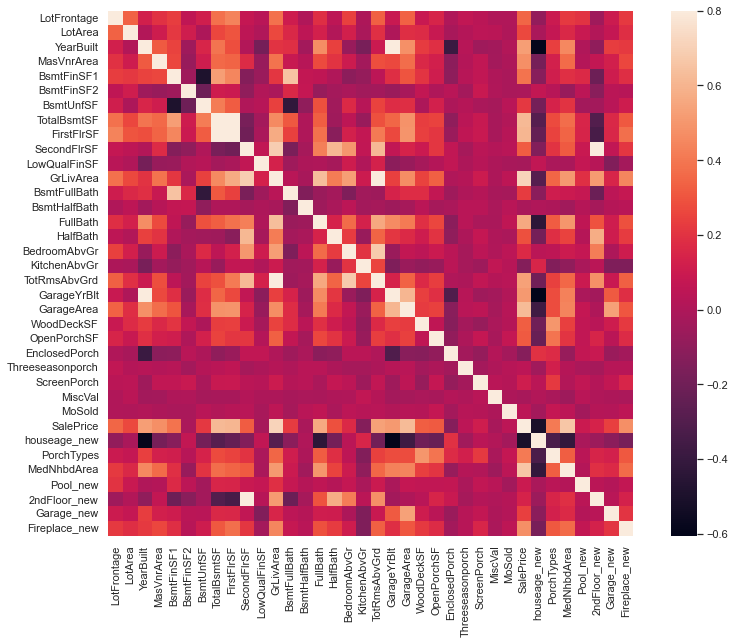

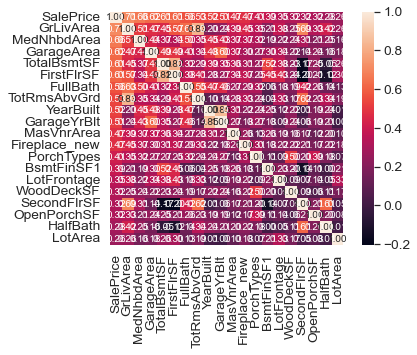

In [570]:
df = feature_engineering.loc[train.index,:].copy()

#correlation matrix: heatmap style
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#saleprice correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## 3.3 ) Plot Analysis and Outlier Detection/ Rejection

Remove outliers, look at shape (maybe model shape or remove skewness)

## 3.3.1 ) Univariate Analysis

In this section the univariate analysis is performed; More importantly I have considered the features that are more important with the 'Target' that  have high corelation with the Target.

For the numeric features I have used a 'distplot' and 'boxplot' to analyze their distribution.

Similarly for categorical features the most reasonable way to visualize the distribution is to use a 'countplot' which shows the relative counts for each category or class. Can use a pie-plot also to be a bit more fancy.

#### NUMERIC FEATURES

In [129]:
def plot_num(feature):
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=df,x=feature,ax=axes[0])
    sns.distplot(a=df[feature],ax=axes[1],color='#ff4125')
    fig.set_size_inches(15,5)

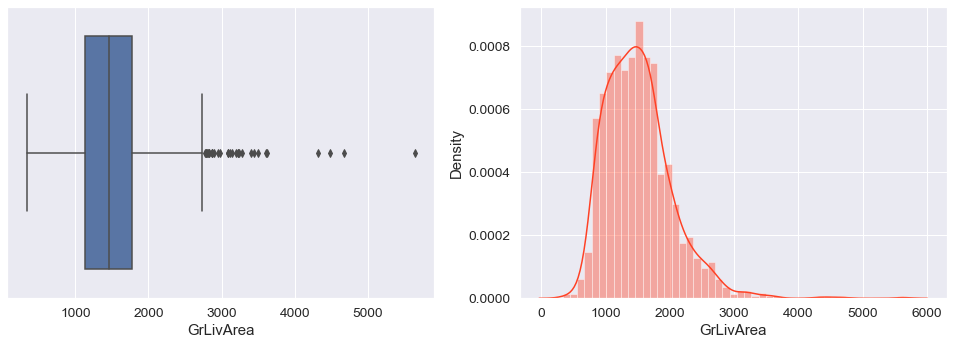

In [130]:
plot_num('GrLivArea')

ValueError: Could not interpret input 'GarageArea'

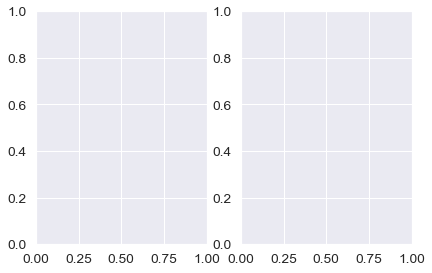

In [131]:
plot_num('GarageArea')

In [ ]:
plot_num('TotalBsmtSF') 

#### Note the features are a bit right skewed. We can therefore take 'log transform' of the features or a BoXCox transformation. Both shall work well. 

#### CATEGORICAL FEATURES

In [801]:
def plot_cat(feature):
  sns.countplot(data=df,x=feature)
  ax=sns.countplot(data=df,x=feature)
   

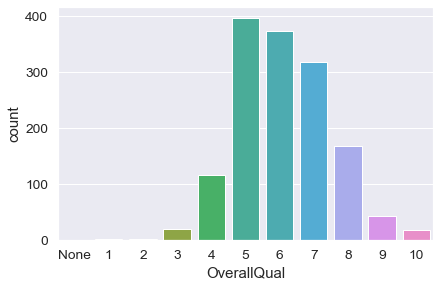

In [802]:
plot_cat('OverallQual')

Most of them are in 'average','above average' or 'good' classes.

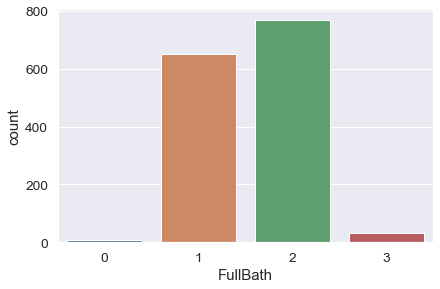

In [803]:
plot_cat('FullBath')

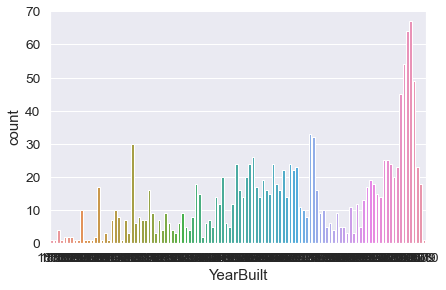

In [804]:
plot_cat('YearBuilt')

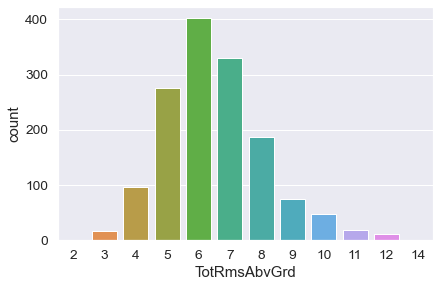

In [805]:
plot_cat('TotRmsAbvGrd') # most of the houses have 5-7 rooms above the grd floor.

#### Lastly we plot the countplot for some important features that are numerical here but are actually categorica. It seems if they have been label encoded.

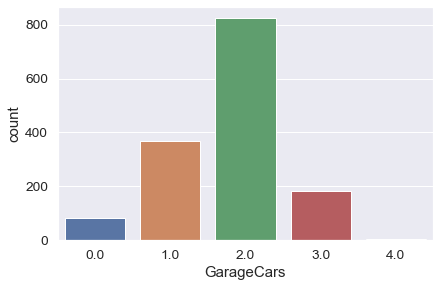

In [806]:
plot_cat('GarageCars')

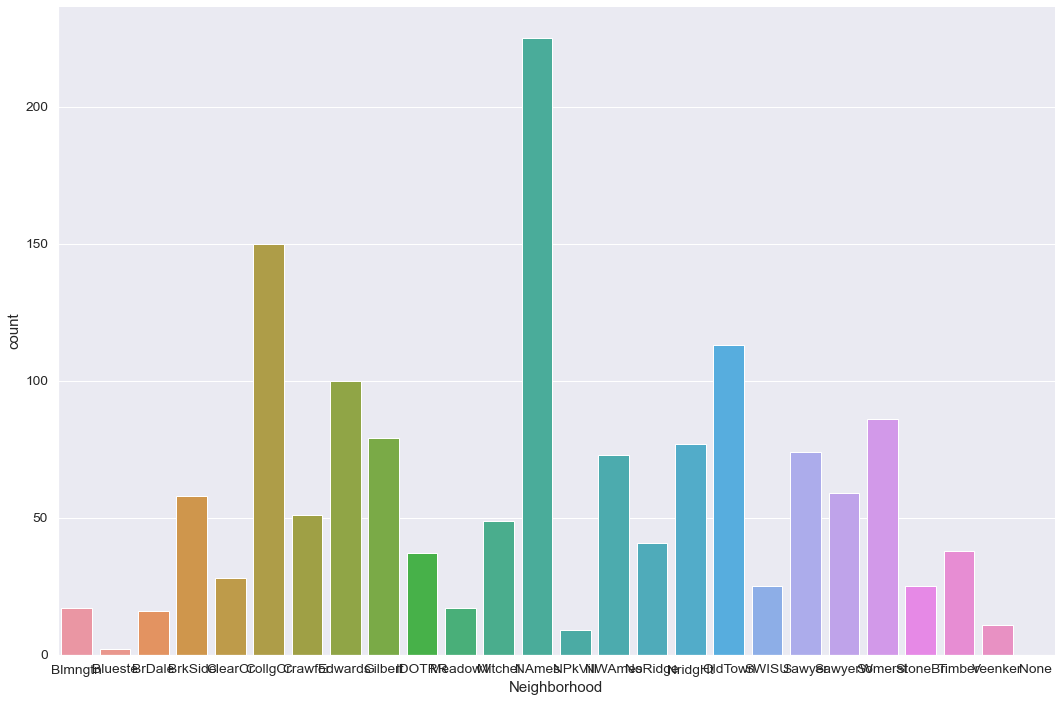

In [807]:
sns.factorplot(data=df,x='Neighborhood',kind='count',size=10,aspect=1.5)

## 3.3.2 ) Bivariate Analysis

In this section the Bivariate Analysis have been done. I have plotted various numeric as well as categorical features against the target ie 'SalePrice'. The focus is on the features that are highly correlated with Sales.

#### NUMERIC FEATURES

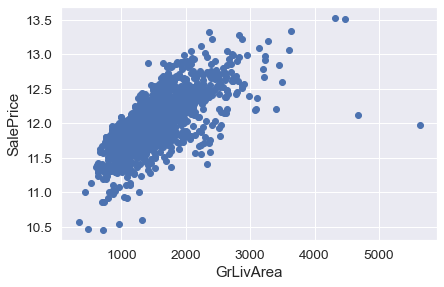

In [808]:
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

#### Note that there are two outliers on the lower right hand side and can remove them.

In [809]:
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<13)].index) # removing some outliers on lower right side.

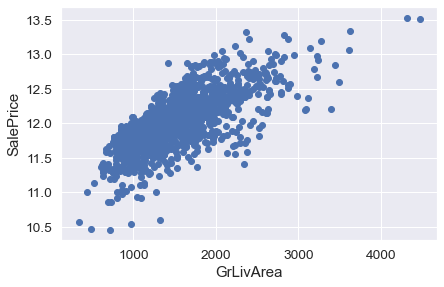

In [810]:
# again checking
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

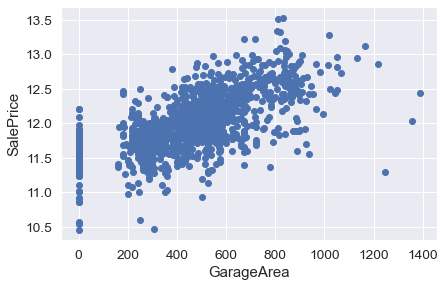

In [811]:
# garage area
fig, ax = plt.subplots()
ax.scatter(x =(df['GarageArea']), y = df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GarageArea')
plt.show()
# can try to fremove the points with gargae rea > than 1200.

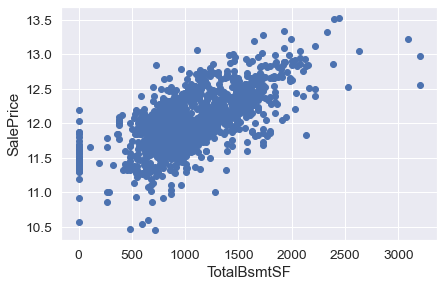

In [812]:
# basment area
fig, ax = plt.subplots()
ax.scatter(x =(df['TotalBsmtSF']), y = df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('TotalBsmtSF')
plt.show()   # check >3000 can leave here.

#### CATEGORICAL FEATURES

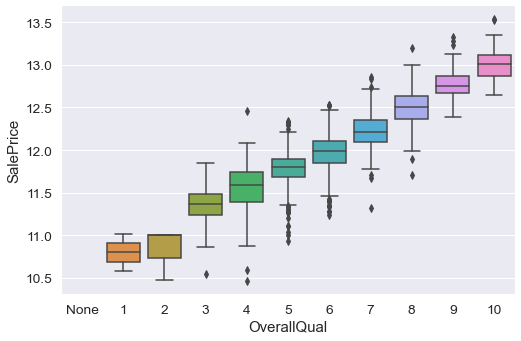

In [813]:
#overall qual
sns.factorplot(data=df,x='OverallQual',y='SalePrice',kind='box',size=5,aspect=1.5)

The SalePrice increases with the overall quality as expected.

**Similar inferences can be drawn from other plots and graphs.**

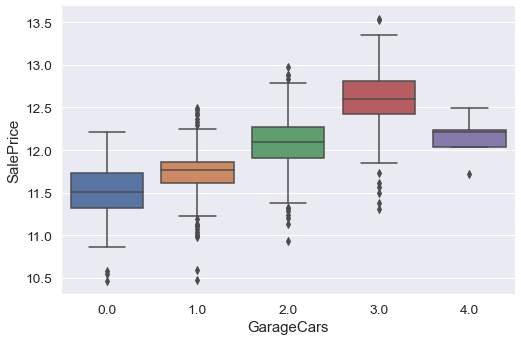

In [814]:
#garage cars
sns.factorplot(data=df,x='GarageCars',y='SalePrice',kind='box',size=5,aspect=1.5)

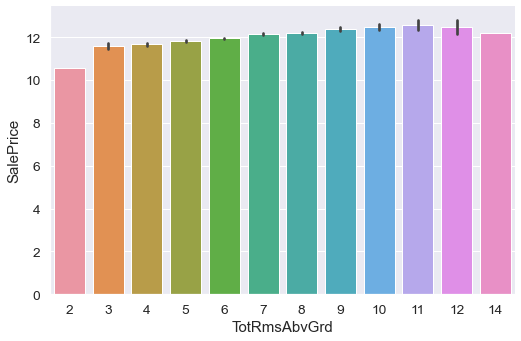

In [815]:
#no of rooms
sns.factorplot(data=df,x='TotRmsAbvGrd',y='SalePrice',kind='bar',size=5,aspect=1.5) # increasing rooms imply increasing SalePrice as expected.

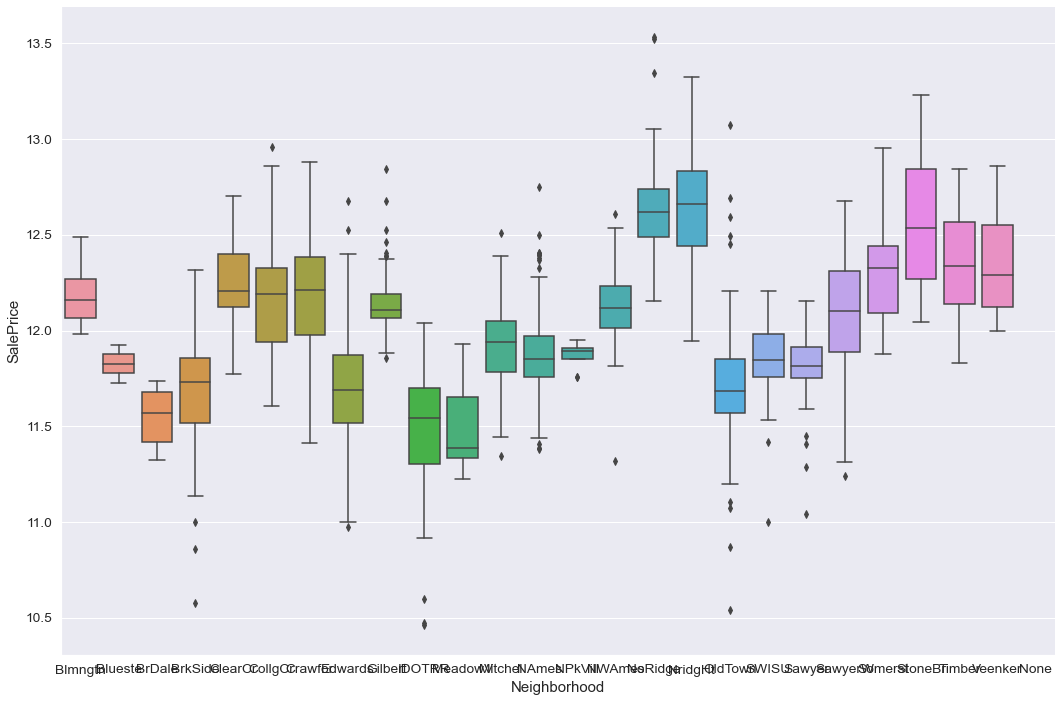

In [816]:
#neighborhood
sns.factorplot(data=df,x='Neighborhood',y='SalePrice',kind='box',size=10,aspect=1.5)

Price varies with neighborhood.More posh areas of the city will have more price as expected.

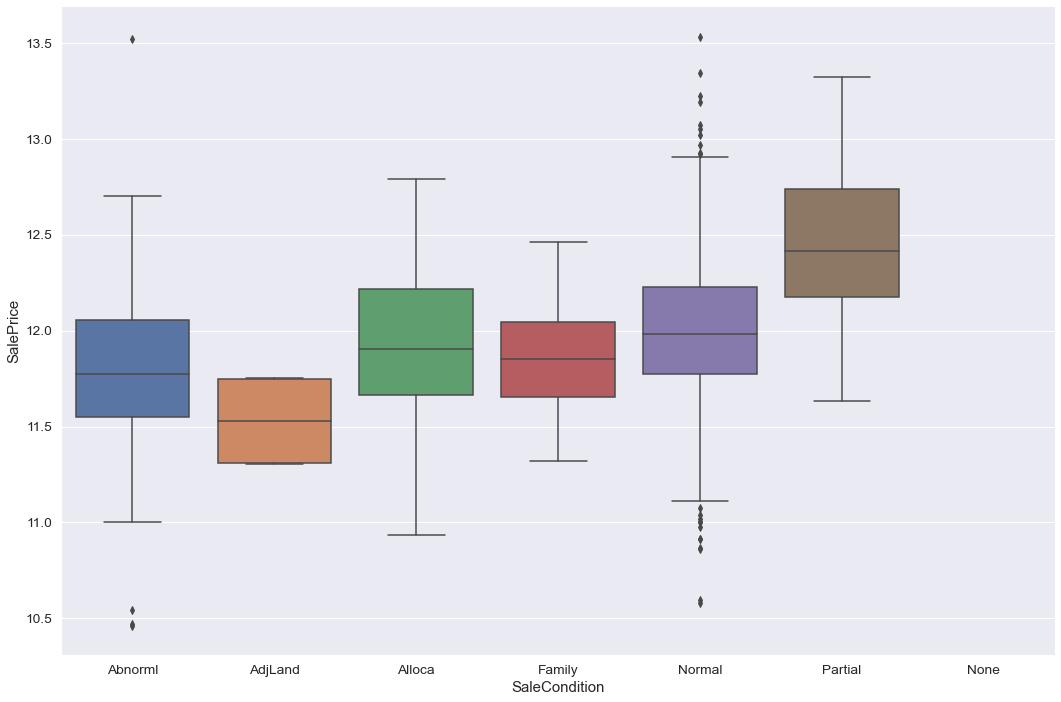

In [817]:
#sale conditioin
sns.factorplot(data=df,x='SaleCondition',y='SalePrice',kind='box',size=10,aspect=1.5)

To analyze the scatter plots between the Sale Price and the most correlated variables, the following can be done:

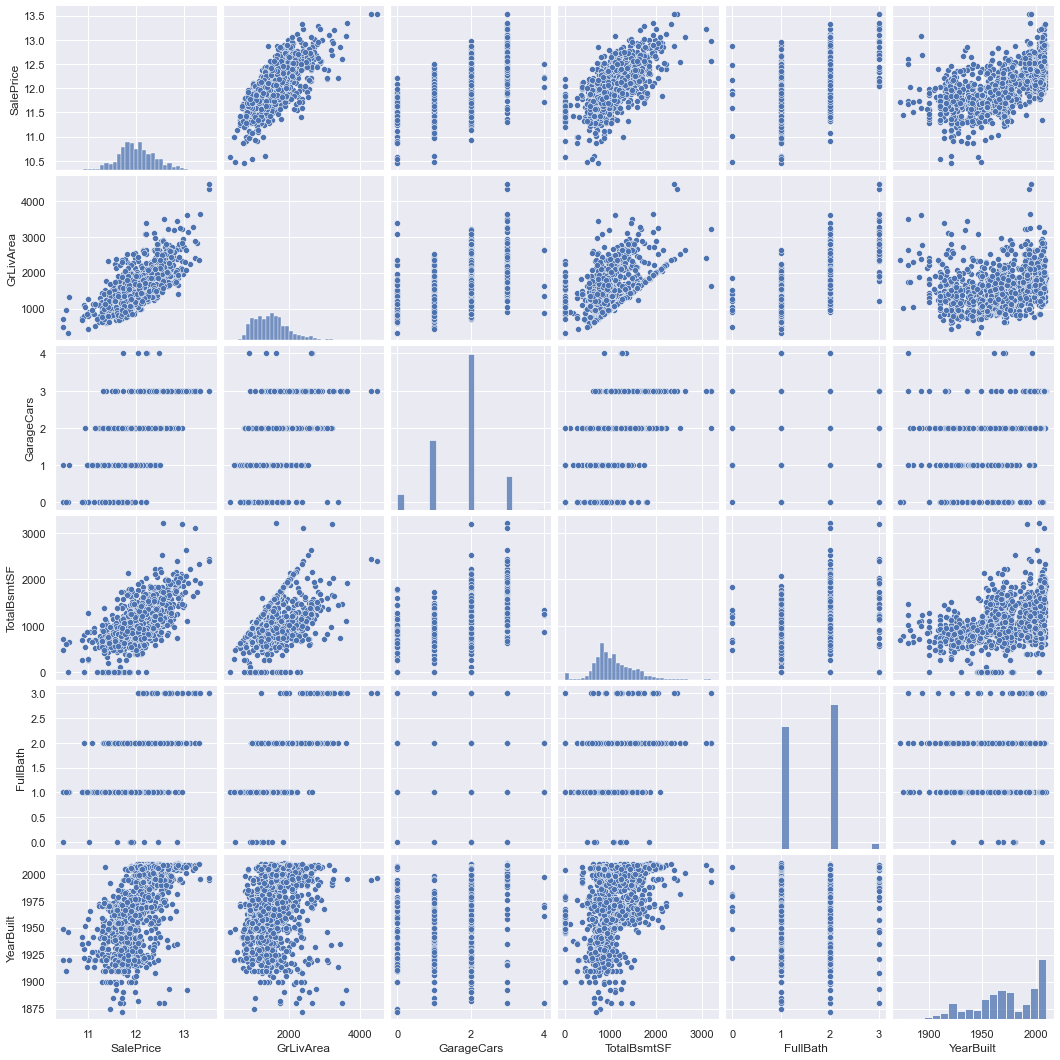

In [818]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show();

### Conclusions:

Although we already know some of the main figures, this mega scatter plot gives us a reasonable idea about variables relationships.

One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area (unless you're trying to buy a bunker).

The plot concerning 'SalePrice' and 'YearBuilt' can also make us think. In the bottom of the 'dots cloud', we see what almost appears to be a shy exponential function (be creative). We can also see this same tendency in the upper limit of the 'dots cloud' (be even more creative). Also, notice how the set of dots regarding the last years tend to stay above this limit (I just wanted to say that prices are increasing faster now).

Ok, enough of Rorschach test for now. Let's move forward to what's missing: missing data!

<a id="content4"></a>
## 3.4 ) Handling Skewness

For handling skewnesss I will take the log transform of the features with skewness > 0.5. A graphical comparison of the univeriate distribution with the normal distribution/ a q-q plot/ estimating kurtosis and skewness can also illustrate the need for a transformation.

You can also try the BoxCox transformation as mentioned before.

The best approach to test homoscedasticity for two metric variables is graphically. Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).

Older versions of this scatter plot (previous to log transformations), had a conic shape (go back and check 'Scatter plots between 'SalePrice' and correlated variables (move like Jagger style)'). As you can see, the current scatter plot doesn't have a conic shape anymore. That's the power of normality! Just by ensuring normality in some variables, we solved the homoscedasticity problem.


In [578]:
#log transform skewed numeric features:
numeric_feats = feature_engineering.dtypes[feature_engineering.dtypes != "category"].index

skewed_feats = feature_engineering[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.50]
print(skewed_feats)
skewed_feats = skewed_feats.index

#Could also try BoxCox and/ or scaling e.g. robust scaler. Look into outlier rejection

all_data_skewness = feature_engineering.copy()
all_data_skewness[skewed_feats] = np.log1p(feature_engineering[skewed_feats])

LotFrontage          1.505704
LotArea             12.822431
MasVnrArea           2.613592
BsmtFinSF1           1.425230
BsmtFinSF2           4.146143
BsmtUnfSF            0.919339
TotalBsmtSF          1.156894
FirstFlrSF           1.469604
SecondFlrSF          0.861675
LowQualFinSF        12.088761
GrLivArea            1.269358
BsmtFullBath         0.624832
BsmtHalfBath         3.931594
HalfBath             0.694566
KitchenAbvGr         4.302254
TotRmsAbvGrd         0.758367
WoodDeckSF           1.842433
OpenPorchSF          2.535114
EnclosedPorch        4.003891
Threeseasonporch    11.376065
ScreenPorch          3.946694
MiscVal             21.947195
SalePrice            1.880941
MedNhbdArea          1.076096
Pool_new            14.884318
dtype: float64


In [591]:
X = feature_engineering.loc[train.index, :].copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline training score: {baseline_score['Training RMSLE']:.5f} RMSLE")
print(f"Baseline CV score: {baseline_score['CV RMSLE']:.5f} RMSLE")

X = all_data_skewness.loc[train.index, :].copy()
z = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Skewness removal training score: {baseline_score['Training RMSLE']:.5f} RMSLE")
print(f"Skewness removal CV score: {baseline_score['CV RMSLE']:.5f} RMSLE")

Baseline training score: 0.00802 RMSLE
Baseline CV score: 0.13374 RMSLE
Skewness removal training score: 0.00802 RMSLE
Skewness removal CV score: 0.13374 RMSLE


<a id="content5"></a>
## 5 ) Prepare the Data

## 5.1 ) LabelEncode the Categorical Features

In [652]:
from sklearn.decomposition import PCA

preprocessed_data = all_data_skewness.copy()

for col in preprocessed_data.columns:
    
    if pd.api.types.is_categorical_dtype(preprocessed_data[col]):  # Correct dtype check
        le=LabelEncoder()
        preprocessed_data[col]=le.fit_transform(preprocessed_data[col])

"""     
# Label Encode Ordinal Features
for col in ordered_levels.keys():  # Only process ordinal features
    if col in preprocessed_data.columns:
        preprocessed_data[col] = preprocessed_data[col].cat.codes  # Convert to numeric order
        
for col in features_nom:  # Only process ordinal features
    if col in preprocessed_data.columns:
        # One-Hot Encode Nominal Features
        preprocessed_data = pd.get_dummies(preprocessed_data, columns=[col], drop_first=True) 
        
# Drop SalePrice only from the training data, test already doesn't have it
train_features = preprocessed_data.loc[train.index, :].drop(columns=["SalePrice"])
test_features = preprocessed_data.loc[test.index, :].drop(columns=["SalePrice"])

pca = PCA(n_components=0.95)  # Retain 95% variance

# Fit PCA on train, transform both train & test
X_train_pca = pca.fit_transform(train_features)
X_test_pca = pca.transform(test_features)

train_processed = pd.DataFrame(X_train_pca, index=train.index)
train_processed["SalePrice"] = preprocessed_data.loc[train.index, "SalePrice"]  # Add target back

test_processed = pd.DataFrame(X_test_pca, index=test.index)

"""


Can ordinal encode the ordinal data, and one hot the rest of the categorical!!!

## 5.2 ) Splitting into Training and Validation Sets

In [635]:
preprocessed_data.shape

(2919, 230)

In [636]:
train_processed = preprocessed_data.loc[train.index,:]
test_processed = preprocessed_data.loc[test.index,:].drop(["SalePrice"], axis = 1)

In [637]:
print(train_processed.shape)
print(test_processed.shape)

(1460, 230)
(1459, 229)


In [638]:
train_processed.tail()

,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_None,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_None
Id,,,,,,,,,,,,,,,,,,,,,
1456,4.143135,8.976894,1,3,3,6,5,1999,0.000000,3,...,0,0,1,0,0,0,0,1,0,0
1457,4.454347,9.486152,1,3,3,6,6,1978,4.787492,3,...,0,0,1,0,0,0,0,1,0,0
1458,4.204693,9.109746,1,3,3,7,9,1941,0.000000,5,...,0,0,1,0,0,0,0,1,0,0
1459,4.234107,9.181735,1,3,3,5,6,1950,0.000000,3,...,0,0,1,0,0,0,0,1,0,0
1460,4.330733,9.204121,1,3,3,5,6,1965,0.000000,4,...,0,0,1,0,0,0,0,1,0,0


Creating a validation set for testing - maybe cross validation would be better instead

In [653]:
x_train,x_test,y_train,y_test=train_test_split(train_processed.drop(['SalePrice'],axis=1),train_processed['SalePrice'],test_size=0.20,random_state=42)

<a id="content6"></a>
## 6 ) Regression Models

Lastly it is the time to apply various regression models and check how are we doing. I have used various regression models from the scikit.

To test: Linear Regression, RF, XGBRregressor, Gradient Boosting Regressor, LGBM Regressor, CatboostRegressor
Ensemble: VotingRegressor, StackingRegressor

Parameter tuning using GridSearchCV is also done to improve performance of some algos - can use this with cross validation instead of having a hold out validation set

#### The evalauton metric that I have used is the Root Mean Squared Error between the 'Log of the actual price' and 'Log of the predicted value' which is also the evaluation metric used by the kaggle.

#### To get abetter idea one may also use the K-fold cross validation insteadof the normal holdout set approach to cross validation.

#### LINEAR REGRESSION

In [654]:
reg_lin=LinearRegression()
reg_lin.fit(x_train,y_train)
pred=reg_lin.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

0.33125191487077793


#### LASSO (and tuning with GridSearchCV)

In [655]:
reg_lasso=Lasso()
reg_lasso.fit(x_train,y_train)
pred=reg_lasso.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

0.33136978510887


In [656]:
params_dict={'alpha':[0.001, 0.005, 0.01,0.05,0.1,0.5,1]}
reg_lasso_CV=GridSearchCV(estimator=Lasso(),param_grid=params_dict,scoring='neg_mean_squared_error',cv=10)
reg_lasso_CV.fit(x_train,y_train)
pred=reg_lasso_CV.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

0.33126029500286686


**Note the significant decrease in the RMSE on tuning the Lasso Regression.**

In [657]:
reg_lasso_CV.best_params_

{'alpha': 0.1}

#### RIDGE (and tuning with GridSearchCV)

In [658]:
reg_ridge=Ridge()
reg_ridge.fit(x_train,y_train)
pred=reg_ridge.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

0.331251914953947


In [659]:
params_dict={'alpha':[0.1, 0.15, 0.20,0.25,0.30,0.35,0.4,0.45,0.50,0.55,0.60]}
reg_ridge_CV=GridSearchCV(estimator=Ridge(),param_grid=params_dict,scoring='neg_mean_squared_error',cv=10)
reg_ridge_CV.fit(x_train,y_train)
pred=reg_ridge_CV.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

0.33125191492067935


In [660]:
reg_ridge_CV.best_params_

{'alpha': 0.6}

#### GRADIENT BOOSTING

In [661]:
#the params are tuned with grid searchCV.

reg_gb=GradientBoostingRegressor(n_estimators=2000,learning_rate=0.05,max_depth=3,min_samples_split=10,max_features='sqrt',subsample=0.75 ,loss='huber')
reg_gb.fit(x_train,y_train)
pred=reg_gb.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

0.3894215756283421


#### XGBoost

In [662]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_xgb.fit(x_train,y_train)
pred=model_xgb.predict(x_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

0.33222875344450803


Note that the parameters aren't optimized. This can get a lot better tahn this for sure.

<a id="content7"></a>
## 7 ) Saving and Making Submission to Kaggle

**The Gradient Boosting gives the best performance on the validation set and so I am using it to make predictions to Kaggle (on the test set).**

In [623]:
# predictions on the test set.
 
pred=reg_gb.predict(test_processed)
pred_act=np.exp(pred)
pred_act=pred_act-1
len(pred_act)

1459

In [624]:
test_id=[]
for i in range (1461,2920):
    test_id.append(i)
d={'Id':test_id,'SalePrice':pred_act}
ans_df=pd.DataFrame(d)
ans_df.head(10)

,Id,SalePrice
0,1461,127680.044598
1,1462,168431.064957
2,1463,192572.665557
3,1464,195117.867789
4,1465,199743.252384
5,1466,174191.153398
6,1467,171478.375038
7,1468,165231.544581
8,1469,176653.537828
9,1470,129275.620199


In [625]:
ans_df.to_csv('answer.csv',index=False)

# Appendix

## Comparing features engineered with their constituents 
This method was not effective, however it is kept here for future reference

In [481]:
new_features_constituents_dict = {"houseage_new": ["YrSold", "YearBuilt"],
                                 "houseremodelage_new":["YrSold", "YearRemodAdd"],
                                 "totalarea_new":["GrLivArea", "TotalBsmtSF"],
                                 "totalbaths_new":["BsmtFullBath", "FullBath", "BsmtHalfBath", "HalfBath"],
                                  "totalporchsf_new":["OpenPorchSF", "Threeseasonporch", "EnclosedPorch", "ScreenPorch", "WoodDeckSF"],
                                  "Pool_new":["PoolArea"],
                                  "2ndFloor_new":["SecondFlrSF"],
                                  "Garage_new":["GarageCars"],
                                  "Bsmt_new":["TotalBsmtSF"],
                                  "Fireplace_new":["Fireplaces"],
                                  "Porch_new":["totalporchsf_new"]
                                 }

def feature_comparator(features_dict):
    df = feature_engineering.loc[train.index,:].copy()

    cor_mat= df.corr()
    #print(cor_mat.SalePrice.sort_values(ascending = False))
    df_list = []
    for key, items in features_dict.items():  # Corrected dictionary iteration
        df = pd.DataFrame(columns = ["Target Correlation", "Target MI", "New Feature Correlation"])
        df.loc[key, "Target Correlation"] = abs(cor_mat.loc['SalePrice', key])
        df.loc[key, "Target MI"] = mi_scores[key]
        df.loc[key, "New Feature Correlation"] = 1
        
        for feature in items:  # Looping over the original features
            
            df.loc[feature, "Target Correlation"] = abs(cor_mat.loc['SalePrice', feature])
            df.loc[feature, "Target MI"] = mi_scores[feature]
            df.loc[feature, "New Feature Correlation"] = abs(cor_mat.loc[key, feature])
    
        df_list.append(df)
    return df_list
            
comparator_dfs = feature_comparator(new_features_constituents_dict)

for data_frame in comparator_dfs:
    print(data_frame)
    print("")

             Target Correlation Target MI New Feature Correlation
houseage_new            0.52335  0.364107                       1
YrSold                 0.028923       0.0                  0.0575
YearBuilt              0.522897   0.40985                0.999036

                    Target Correlation Target MI New Feature Correlation
houseremodelage_new           0.509079   0.29098                       1
YrSold                        0.028923       0.0                0.028592
YearRemodAdd                  0.507101  0.276189                 0.99793

              Target Correlation Target MI New Feature Correlation
totalarea_new           0.778959  0.661989                       1
GrLivArea               0.708624  0.431811                0.880324
TotalBsmtSF             0.613581  0.366716                0.822888

               Target Correlation Target MI New Feature Correlation
totalbaths_new           0.631731  0.334232                       1
BsmtFullBath             0.227122    

## Conclusions:
* Drop houseage_new and YrSold 
* Drop YrSold and YearRemodAdd 
* Test Dropping GrLivAreaa and TotalBsmtSF
* Drop BsmtFullBath, FullBath, BsmtHalfBath, HalfBath
* Drop OpenPorchSF, Threeseasonporch, EnclosedPorch, ScreenPorch, WoodDeckSF
* Drop Pool_new and PoolArea
* Drop 2ndFloor_new
* Drop Garage_new
* Drop Bsmt_new
* Drop Fireplaces
* Drop Porch_new

In [428]:
X = all_data_complex_impute.loc[train.index, :].copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Improved imputation training score: {baseline_score['Training RMSLE']:.5f} RMSLE")
print(f"Improved imputation CV score: {baseline_score['CV RMSLE']:.5f} RMSLE")

X = feature_engineering.loc[train.index, :].copy()
y = X.pop("SalePrice")

feature_engineering_score = score_dataset(X, y)
print(f"Feature engineering training score: {feature_engineering_score['Training RMSLE']:.5f} RMSLE")
print(f"Feature engineering  CV score: {feature_engineering_score['CV RMSLE']:.5f} RMSLE")

feature_engineering_dropped = feature_engineering.drop(["GarageArea", "houseage_new", "YrSold", "YearRemodAdd", "BsmtFullBath", "FullBath", "BsmtHalfBath",
                                                  "HalfBath", "OpenPorchSF", "Threeseasonporch", "EnclosedPorch", "ScreenPorch", "WoodDeckSF",
                                                  "Pool_new", "PoolArea", "2ndFloor_new", "Garage_new", "Bsmt_new", "Fireplaces", "Porch_new", "total", "TotalBasement"], 
                                                 axis = 1)


X = feature_engineering_dropped.loc[train.index, :].copy()
y = X.pop("SalePrice")

feature_engineering_dropped_score = score_dataset(X, y)
print(f"Feature engineering dropped training score: {feature_engineering_dropped_score['Training RMSLE']:.5f} RMSLE")
print(f"Feature engineering dropped CV score: {feature_engineering_dropped_score['CV RMSLE']:.5f} RMSLE")


Improved imputation training score: 0.00748 RMSLE
Improved imputation CV score: 0.13481 RMSLE
Feature engineering training score: 0.00742 RMSLE
Feature engineering  CV score: 0.13907 RMSLE
Feature engineering dropped training score: 0.00850 RMSLE
Feature engineering dropped CV score: 0.13556 RMSLE
